In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F


from ray import tune
from ray.tune.examples.mnist_pytorch import get_data_loaders, train, test

In [2]:
import numpy as np
import random
import sys
import pickle
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import accuracy_score
import seaborn as sns

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skorch import NeuralNetRegressor

from sklearn.model_selection import GridSearchCV
from collections import defaultdict
from sklearn import metrics
import pandas as pd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
print(device)  

cuda:0


### load pre-process data

In [3]:
class GTZANDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx][0]
        y = self.data[idx][1]
        
        if self.transform:
            x = self.transform(x)
        
        x = torch.Tensor(x)

        return (x, y)

batch_size = 5


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

raw_trainset = pickle.load(open('data/GTZAN_resized.train', 'rb'))
trainset = GTZANDataset(raw_trainset)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

raw_testset = pickle.load(open('data/GTZAN_resized.test', 'rb'))
testset = GTZANDataset(raw_testset)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)


classes = ('blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock')

In [4]:
class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3,padding=1),
            nn.BatchNorm2d(64,momentum=0.1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 64, kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2)       
        )
   
        # flatten 
        self.fc = nn.Sequential(
            nn.Linear(512*2*10,1000),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1000,100),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(100,10),           
        )
        self.dropOut = nn.Dropout(0.1)
        
    def forward(self, x):

        x = self.main(x)
#         print ('x shape: ', x.shape)
        x = x.view(-1, 512*2*10) 
       
        x = self.fc(x) 
        x = self.dropOut(x)
        return x
        

In [5]:
def train(net, opt, trainloader, loss_func, device): 
    net.train()
    avg_losses = []   # Avg. losses.
   
    epochs = 10       # Total epochs.
    print_freq = 100  # Print frequency.

    try:
        for epoch in range(epochs):  # Loop over the dataset multiple times.
    
            running_loss = 0.0 
            for i, data in enumerate(trainloader):

                # Get the inputs.
                inputs, labels = data
                
                # Move the inputs to the specified device.
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the parameter gradients.
                opt.zero_grad()

                # Forward step.
                outputs = net(inputs)
                loss = loss_func(outputs, labels)

                # Backward step.
  
                loss.backward()
                # Optimization step (update the parameters).
   
                opt.step()
                # Print statistics.
    
#                 running_loss += loss.item()
#                 if i % print_freq == print_freq - 1: # Print every several mini-batches.
    
#                     avg_loss = running_loss / print_freq
# #                     print('[epoch: {}, i: {:5d}] avg mini-batch loss_net: {:.3f}'.format(
# #                         epoch, i, avg_loss))
                    
    
#                     avg_losses.append(avg_loss)
   
#                     running_loss = 0.0

        print('Finished Training.')
    except KeyboardInterrupt:
        print('Halted Training')

In [6]:
def test(net, testloader, device):
    # Get test accuracy.
    correct_net = 0
    net.eval()
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs_net = net(images)
            
            _, predicted_net = torch.max(outputs_net.data, 1)
            
            total += labels.size(0)
            correct_net += (predicted_net == labels).sum().item()
            

    return (correct_net / total)

In [9]:
def train_test(config):
    model = cnn()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.SGD(
        model.parameters(), lr=config["lr"], momentum=config["momentum"])
    loss_func = nn.CrossEntropyLoss()  
    for i in range(3):
        train(model, optimizer, trainloader, loss_func, device)
        acc = test(model, testloader, device)
        tune.track.log(mean_accuracy=acc)

In [10]:
search_space = {
    "lr": tune.choice([0.001, 0.01, 0.1]),
    "momentum": tune.uniform(0.1, 0.9)
}
analysis = tune.run(train_test, config=search_space)

2020-06-10 11:08:08,191	WARNING tune.py:316 -- Tune detects GPUs, but no trials are using GPUs. To enable trials to use GPUs, set tune.run(resources_per_trial={'gpu': 1}...) which allows Tune to expose 1 GPU to each trial. You can also override `Trainable.default_resource_request` if using the Trainable API.
2020-06-10 11:08:08,597	ERROR logger.py:196 -- pip install 'ray[tune]' to see TensorBoard files.
2020-06-10 11:08:08,598	WARNING logger.py:328 -- Could not instantiate TBXLogger: No module named 'tensorboardX'.
2020-06-10 11:08:09,199	WARNING worker.py:1090 -- Warning: The actor WrappedTrackFunc has size 42293844 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


Trial name,status,loc,lr,momentum
train_test_00000,RUNNING,,0.001,0.51714


(pid=4910) 2020-06-10 11:08:10,041	INFO trainable.py:217 -- Getting current IP.
(pid=4910) Finished Training.
Result for train_test_00000:
  date: 2020-06-10_11-15-09
  done: false
  experiment_id: 2780b77b0aa24130a639db2bd1c304e3
  experiment_tag: 0_lr=0.001,momentum=0.51714
  hostname: dsmlp-jupyter-rol044
  iterations_since_restore: 1
  mean_accuracy: 0.595
  node_ip: 10.46.128.10
  pid: 4910
  time_since_restore: 419.948921918869
  time_this_iter_s: 419.948921918869
  time_total_s: 419.948921918869
  timestamp: 1591812909
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00000'
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_test_00000,RUNNING,10.46.128.10:4910,0.001,0.51714,0.595,0,419.949


(pid=4910) Finished Training.
Result for train_test_00000:
  date: 2020-06-10_11-21-45
  done: false
  experiment_id: 2780b77b0aa24130a639db2bd1c304e3
  experiment_tag: 0_lr=0.001,momentum=0.51714
  hostname: dsmlp-jupyter-rol044
  iterations_since_restore: 2
  mean_accuracy: 0.71
  node_ip: 10.46.128.10
  pid: 4910
  time_since_restore: 815.6569902896881
  time_this_iter_s: 395.7080683708191
  time_total_s: 815.6569902896881
  timestamp: 1591813305
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '00000'
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_test_00000,RUNNING,10.46.128.10:4910,0.001,0.51714,0.71,1,815.657


(pid=4910) Finished Training.
Result for train_test_00000:
  date: 2020-06-10_11-27-57
  done: false
  experiment_id: 2780b77b0aa24130a639db2bd1c304e3
  experiment_tag: 0_lr=0.001,momentum=0.51714
  hostname: dsmlp-jupyter-rol044
  iterations_since_restore: 3
  mean_accuracy: 0.685
  node_ip: 10.46.128.10
  pid: 4910
  time_since_restore: 1187.1576597690582
  time_this_iter_s: 371.5006694793701
  time_total_s: 1187.1576597690582
  timestamp: 1591813677
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: '00000'
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_test_00000,RUNNING,10.46.128.10:4910,0.001,0.51714,0.685,2,1187.16


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_test_00000,TERMINATED,,0.001,0.51714,0.685,2,1187.16


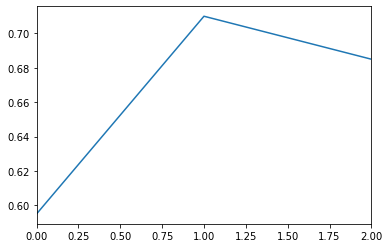

In [11]:
dfs = analysis.trial_dataframes

# Plot by epoch
ax = None  # This plots everything on the same plot
for d in dfs.values():
    ax = d.mean_accuracy.plot(ax=ax, legend=False)

In [15]:
analysis.runner_data()

{'_global_time_limit': inf,
 '_total_time': 1558.6583292484283,
 '_iteration': 5,
 '_has_errored': False,
 '_fail_fast': False,
 '_verbose': True,
 '_server_port': 4321,
 '_cached_trial_decisions': {},
 '_should_stop_experiment': False,
 '_local_checkpoint_dir': '/home/rol044/ray_results/train_test',
 '_remote_checkpoint_dir': None,
 '_stopper': {'_type': 'CLOUDPICKLE_FALLBACK',
  'value': '80049527000000000000008c107261792e74756e652e73746f70706572948c0b4e6f6f7053746f707065729493942981942e'},
 '_resumed': False,
 '_start_time': 1591812487.9376132,
 '_last_checkpoint_time': 1591813677.2461417,
 '_checkpoint_period': 10,
 '_session_str': '2020-06-10_11-08-07',
 'checkpoint_file': '/home/rol044/ray_results/train_test/experiment_state-2020-06-10_11-08-07.json',
 'launch_web_server': False}

In [24]:
dfs

{'/home/rol044/ray_results/train_test/train_test_0_lr=0.001,momentum=0.51714_2020-06-10_11-08-08rsbw9kg5':    mean_accuracy  trial_id  training_iteration  time_this_iter_s   done  \
 0          0.595         0                   0        419.948922  False   
 1          0.710         0                   1        395.708068  False   
 2          0.685         0                   2        371.500669  False   
 
    timesteps_total  episodes_total                     experiment_id  \
 0              NaN             NaN  2780b77b0aa24130a639db2bd1c304e3   
 1              NaN             NaN  2780b77b0aa24130a639db2bd1c304e3   
 2              NaN             NaN  2780b77b0aa24130a639db2bd1c304e3   
 
                   date   timestamp  time_total_s   pid              hostname  \
 0  2020-06-10_11-15-09  1591812909    419.948922  4910  dsmlp-jupyter-rol044   
 1  2020-06-10_11-21-45  1591813305    815.656990  4910  dsmlp-jupyter-rol044   
 2  2020-06-10_11-27-57  1591813677   1187.157660  